In [1]:
%load_ext autoreload
%autoreload complete

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tqdm.notebook import tqdm

set_matplotlib_formats("svg")

In [5]:
from sklearn.linear_model import BayesianRidge, LassoLarsIC, LinearRegression
from sklearn.multioutput import MultiOutputRegressor

from src.features.time_series import TimeSeriesRegressor

lr = LinearRegression()
lasso = MultiOutputRegressor(LassoLarsIC())
ridge = MultiOutputRegressor(BayesianRidge())

lags = {
    (0, 0): vars.future_only,
    (0, 1): vars.future,
    (1, 1): vars.y,
}
model = TimeSeriesRegressor(lr, y_cols=vars.y, lags=lags).fit_multiple(
    dfs, static_covariates="dummies"
)

### Interpretability: coefficients

In [6]:
model.get_most_important_coefficients("media_protest").head(20)

,target,predictor,lag,coef
0,media_protest,weekday_Sunday,0,-1.142456
1,media_protest,is_holiday,0,-0.877595
2,media_protest,occ_FFF,1,0.731773
3,media_protest,occ_FFFX,1,-0.369523
4,media_protest,weekday_Monday,0,0.342858
5,media_protest,weekday_Saturday,0,0.337174
6,media_protest,occ_ALG,1,0.333060
7,media_protest,occ_FFF,0,0.229114
8,media_protest,media_not_protest,1,0.191948
9,media_protest,occ_ALG,0,0.176982


## Via prediction

In [7]:
vars_w = [c for c in model.X_lagged.columns if c.startswith("occ_")]
X_lagged = model.X_lagged
y_pred = model._predict(X_lagged)
X_lagged[vars_w] = 0
y_pred_cf = model._predict(X_lagged)

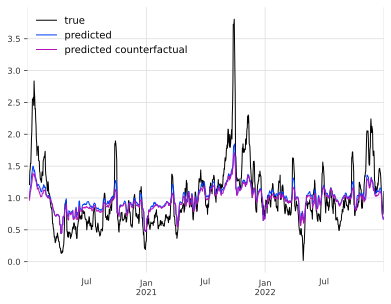

In [8]:
fig, ax = plt.subplots()
model.y.groupby(model.y.index).mean()[["media_protest"]].rolling(7).mean().plot(
    ax=ax, linewidth=1
)
y_pred.groupby(y_pred.index).mean()[["media_protest"]].rolling(7).mean().plot(
    ax=ax, linewidth=1
)
y_pred_cf.groupby(y_pred_cf.index).mean()[["media_protest"]].rolling(7).mean().plot(
    ax=ax, linewidth=1
)
plt.legend(["true", "predicted", "predicted counterfactual"])
plt.show()

In [9]:
y_pred.sum() / y_pred_cf.sum()

media_protest            1.036513
media_not_protest        1.001026
media_framing            1.044344
media_goal               1.011370
media_subsidiary_goal    1.009212
dtype: float64

In [10]:
y_pred.sum() - y_pred_cf.sum()

media_protest            579.126938
media_not_protest         16.855459
media_framing            698.066523
media_goal               184.827154
media_subsidiary_goal    150.055192
dtype: float64

In [11]:
y_pred.sum()

media_protest            16440.0
media_not_protest        16440.0
media_framing            16440.0
media_goal               16440.0
media_subsidiary_goal    16440.0
dtype: float64